<a href="https://colab.research.google.com/github/kbyshiro/CMAPSS_tasks/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ライブラリのインポート


In [8]:
# Gitのクローン
!git clone  https://github.com/kbyshiro/CMAPSS_tasks.git "gitproject"

fatal: destination path 'gitproject' already exists and is not an empty directory.


In [9]:
import os
import sys
sys.path.append('/content/gitproject/library/')
sys.path.append('/content/gitproject/model/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
sns.set()
# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [10]:
from fd_dataset import FD_Dataset 
from models import LSTMRegressor

In [11]:
fd = FD_Dataset()
fd.load(data_id=1)
fd.MinMaxNorm()

# RULに制限を設ける。
RUL_limit = 130
fd.LimitRUL(RUL_limit=RUL_limit)

In [12]:
Y_max = fd.train.t.max()
print(Y_max)

130


#データローダーの準備

In [13]:
#tuning parameters
window_size = 30
batch_size = 100
cut_size = 10

In [14]:
train = fd.SlideWindow(fd.train, window_size, mode='LSTM')
test = fd.SlideWindow(fd.test, window_size,mode='LSTM')
dataloader = torch.utils.data.DataLoader(train, batch_size= batch_size)

学習モデル

In [15]:
# model parameter
lstm_input_layer = 14
lstm_hidden_layer = 50
lstm_output_layer = 1

#訓練

In [25]:
# training epoches
n_epoches = 100
UnitSize = fd.raw_train["UnitNumber"].max()
print(UnitSize)

100


In [ ]:
class SCORE(nn.Module):
  def __init__(self):
      super(SCORE, self).__init__()

  def coef(self, targets, Y_max):
    return targets/Y_max

  def Error1(self, inputs, targets):
    yr = inputs - targets
    ret = torch.Tensor([torch.exp(y/10)-1 if y >= 0 else torch.exp(-y/13)-1 for y in yr])
    return ret

  def Error2(self, inputs, targets):
    yr= inputs - targets
    ret = torch.Tensor([torch.exp(y/13)-1 if y >= 0 else torch.exp(-y/10)-1 for y in yr])
    return ret

  def forward(self, inputs, targets):
    cf = self.coef(targets, Y_max)
    loss = ((1-cf)*self.Error1(inputs, targets)+cf*self.Error2(inputs, targets)).sum()
    return loss

In [ ]:
#training
model = LSTMRegressor(lstm_input_layer, lstm_hidden_layer, lstm_output_layer)
loss_fn = nn.MSELoss()
score_fn = SCORE()
optimizer = optim.Adam(model.parameters(), lr=.005)
UnitLoss = [[] for _ in range(UnitSize)] # unit毎、EPOCH毎のLOSSの推移
for epoch in range(n_epoches):
    for i, data in enumerate(dataloader):
        x_batch, y_batch = data
        optimizer.zero_grad()
        model.init_hidden(len(x_batch))
        #calc 
        y_pred = model(x_batch)
        loss = loss_fn(y_pred.view(-1), y_batch)
        # update
        loss.backward()
        optimizer.step()
      
    with torch.no_grad():
        for i in range(UnitSize):
            

    if epoch%10 == 9:
        print('epoch: {0:3}: LOSS: {1:10.8f}'.format(epoch+1, loss_his[epoch]))
print('Done!')

epoch:  10: LOSS: 1245059353.96292305
epoch:  20: LOSS: 793170846.23459780
epoch:  30: LOSS: 340846.62447448
epoch:  40: LOSS: 46502.75154260
epoch:  50: LOSS: 29432.41936774
epoch:  60: LOSS: 33759.71877077
epoch:  70: LOSS: 33329.50575063
epoch:  80: LOSS: 33594.94111138
epoch:  90: LOSS: 36723.37224609
epoch: 100: LOSS: 42950.77417477
Done!


In [ ]:
y_true = test.t
with torch.no_grad():
    model.init_hidden(test.X.size(0))
    y_pred = model(test.X)
    loss_test = loss_fn(y_pred.view(-1), y_true)
print('LOSS: {}'.format(np.sqrt(loss_test)))

LOSS: 166.5906982421875


#結果の表示

(-10.0, 100000.0)

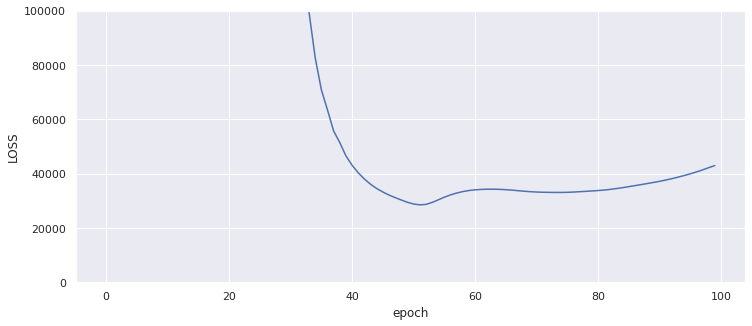

In [ ]:
f = plt.figure(figsize=(12, 5))
plt.plot(loss_his, label='LOSS')
plt.xlabel('epoch')
plt.ylabel('LOSS')
plt.ylim((-10, 100000))

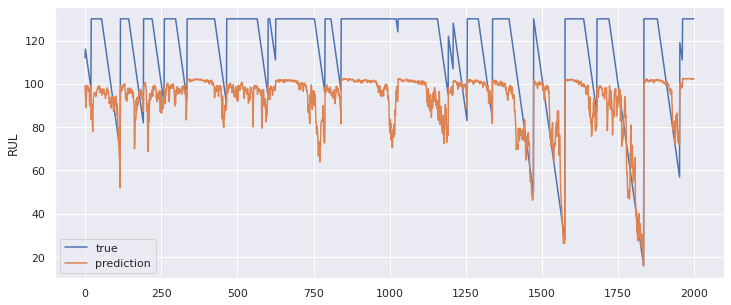

In [ ]:
f= plt.figure(figsize=(12, 5))
plt.plot(y_true[:2000], label='true')
plt.plot(y_pred[:2000], label='prediction')
plt.ylabel('RUL')
plt.legend()

No handles with labels found to put in legend.


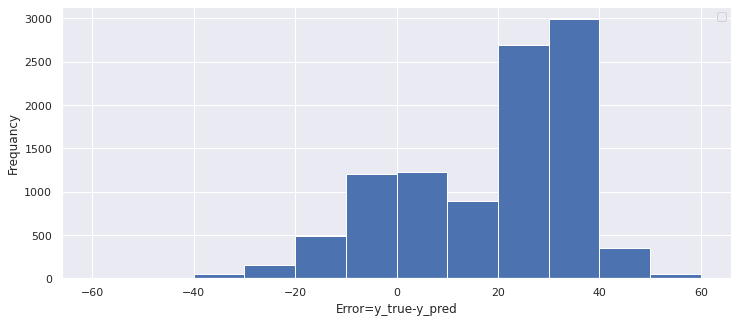

In [ ]:
f= plt.figure(figsize=(12, 5))
plt.hist(y_true-y_pred.view(-1), range=(-60, 60), bins=12)
plt.xlabel('Error=y_true-y_pred')
plt.ylabel('Frequancy')
plt.legend()

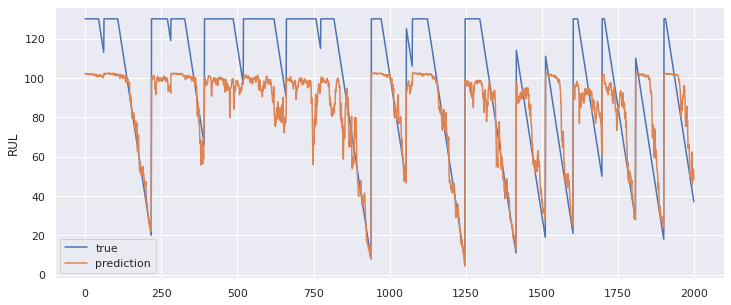

In [ ]:
f= plt.figure(figsize=(12, 5))
plt.plot(y_true[2000:4000], label='true')
plt.plot(y_pred[2000:4000], label='prediction')
plt.ylabel('RUL')
plt.legend()

No handles with labels found to put in legend.


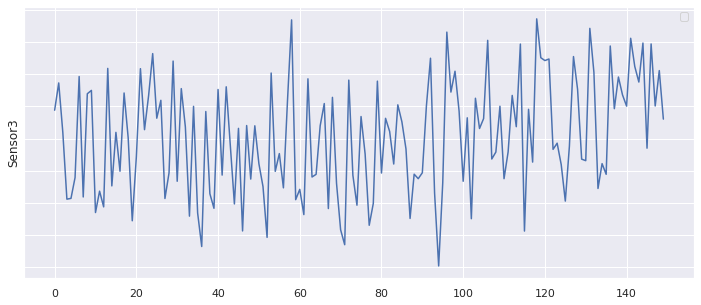

In [ ]:
f= plt.figure(figsize=(12, 5))
plt.plot(fd.raw_train['Sensor_3'][:150])
plt.tick_params(labelleft=False)
plt.ylabel('Sensor3')
plt.legend()